In [1]:
from massspecgym.data.datasets import MSnDataset, MassSpecDataset
from massspecgym.data.transforms import MolFingerprinter, SpecTokenizer
from massspecgym.data import MassSpecDataModule
from massspecgym.featurize import SpectrumFeaturizer

from scipy.stats import kruskal, spearmanr, linregress
from statsmodels.stats.multitest import multipletests
from scikit_posthocs import posthoc_dunn
from collections import defaultdict
from itertools import combinations
from typing import List
from scipy import stats
from math import comb
import numpy as np
import random
import pandas as pd
from typing import List, Dict, Tuple, Optional, Any

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats


from matplotlib.patches import Patch, Polygon
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.nonparametric.smoothers_lowess import lowess

import warnings


from massspecgym.tools.data import (compute_cosine_hungarian_score, compute_pairwise_similarity_by_mslevel, compute_same_level_similarity_limited,compute_ancestor_descendant_similarity, compute_sibling_similarity, random_node_pairs)

from massspecgym.tools.plots import plot_histograms, plot_histograms_by_level_pairs
from massspecgym.tools.io import load_embeddings

In [2]:
from massspecgym.tools.statistics import (summarize_similarity_distribution, 
                                          perform_statistical_tests_with_effect_sizes,
                                          summarize_all_level_pairs,)

## Local functions definitions

In [ ]:
# For similarity function (hungarian_fn)
def hungarian_fn(specA, specB):
    (sc, _) = compute_cosine_hungarian_score(specA, specB, tolerance=0.1)
    return (sc, 0)

def convert_similarity_scores(similarity_scores):
    """
    Convert a list of numpy.ndarray similarity scores to a list of floats.
    """
    return [float(score) for score in similarity_scores]

def report_comparison_results_with_effect_sizes(comparison_results: List[Dict[str, Any]]):
    """
    Print comparison results with effect sizes in a structured format.
    
    Parameters:
    - comparison_results: List of dictionaries containing comparison details
    """
    if not comparison_results:
        print("No comparisons to report.")
        return
    
    df = pd.DataFrame(comparison_results)
    
    df = df[[
        "Group 1", 
        "Group 2", 
        "Test Used", 
        "Statistic", 
        "p-value", 
        "Adjusted Alpha",
        "Significant",
        "Effect Size",
        "Effect Size Type"
    ]]
    
    # Sort by p-value
    df = df.sort_values(by="p-value")
    
    print(df.to_string(index=False))

def plot_boxplots(all_level_sims: Dict[Tuple[int, int], List[float]], title: str):
    """
    Plot boxplots of similarity scores for multiple level pairs.
    
    Parameters:
    - all_level_sims: Dict mapping level pairs to list of similarity scores
    - title: Title of the plot
    """
    data = []
    for (lvlA, lvlB), sims in all_level_sims.items():
        label = f"{lvlA}-{lvlB}"
        for sim in sims:
            data.append({"Level Pair": label, "Similarity": sim})
    
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(14, 8))
    sns.boxplot(x="Level Pair", y="Similarity", data=df, palette="Set3")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel("MS Level Pair")
    plt.ylabel("Similarity Score")
    plt.show()

def plot_density(all_level_sims: Dict[Tuple[int, int], List[float]], title: str):
    """
    Plot density plots of similarity scores for all level pairs.
    
    Parameters:
    - all_level_sims: Dict mapping level pairs to list of similarity scores
    - title: Title of the plot
    """
    plt.figure(figsize=(14, 8))
    for (lvlA, lvlB), sims in all_level_sims.items():
        label = f"{lvlA}-{lvlB}"
        sns.kdeplot(sims, label=label, shade=False)
    
    plt.title(title)
    plt.xlabel("Similarity Score")
    plt.ylabel("Density")
    plt.legend(title="MS Level Pairs", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

def downsample_all_level_sims(all_level_sims_hung, desired_size=None, random_seed=42):
    """
    Downsample each group in the all_level_sims_hung dictionary to the desired_size.
    If desired_size is not specified, it defaults to the size of the smallest group.
    
    Parameters:
    - all_level_sims_hung (dict): Dictionary with Level_Pair tuples as keys and lists of similarity scores as values.
    - desired_size (int, optional): The number of samples to retain in each group.
                                    Defaults to the size of the smallest group.
    - random_seed (int, optional): Seed for reproducibility.
    
    Returns:
    - downsampled_dict (dict): Dictionary with downsampled similarity scores.
    """
    random.seed(random_seed)
    
    # Determine the default desired_size as the size of the smallest group
    if desired_size is None:
        desired_size = min(len(scores) for scores in all_level_sims_hung.values())
        print(f"Desired sample size per group set to the smallest group size: {desired_size}")
    else:
        print(f"Desired sample size per group set to: {desired_size}")
    
    downsampled_dict = {}
    for pair, scores in all_level_sims_hung.items():
        current_size = len(scores)
        if current_size > desired_size:
            # Randomly sample without replacement
            sampled_scores = random.sample(scores, desired_size)
            downsampled_dict[pair] = sampled_scores
            print(f"Downsampled group {pair} from {current_size} to {desired_size}")
        elif current_size < desired_size:
            # Optionally, handle groups smaller than desired_size
            # For now, we will keep them as is
            downsampled_dict[pair] = scores
            print(f"Group {pair} has only {current_size} samples; no downsampling performed.")
        else:
            # No downsampling needed
            downsampled_dict[pair] = scores
            print(f"Group {pair} already has {desired_size} samples; no downsampling performed.")
    
    return downsampled_dict

In [3]:
file_mgf = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_msn_library_pos_all_lib_MSn.mgf"
split_file = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_split.tsv"

In [4]:
config = {
    'features': ['binned_peaks'],
    'feature_attributes': {
        'binned_peaks': {
            'max_mz': 1,
            'bin_width': 1.0,
        },
    },
}

featurizer = SpectrumFeaturizer(config, mode='torch')

In [5]:
# Init hyperparameters
n_peaks = 60
fp_size = 4096
batch_size = 12

msn_dataset = MSnDataset(
    pth=file_mgf,
    featurizer=featurizer,
    mol_transform=MolFingerprinter(fp_size=fp_size),
    max_allowed_deviation=0.005
)

In [7]:
# MS-Level Pair Analysis (hungarian_fn based)
all_level_sims_hung = defaultdict(list)

for tree in msn_dataset.trees:
    level_sims_dict = compute_pairwise_similarity_by_mslevel(
        tree, use_embedding=False, sim_fn=hungarian_fn, descendant_mode=True,
    )
    for (lvlA, lvlB), simvals in level_sims_dict.items():
        all_level_sims_hung[(lvlA, lvlB)].extend(simvals)

In [8]:
# Limited MS2<->MS2 similarities (hungarian_fn)
ms2_sims_hung, _ = compute_same_level_similarity_limited(
    msn_dataset,
    target_level=2,
    use_embedding=False,
    sim_fn=hungarian_fn,
    tolerance=0.1,
    max_pairs=25000
)

In [9]:
# Initialize (2,2) if not present
if (2, 2) not in all_level_sims_hung:
    all_level_sims_hung[(2, 2)] = []

all_level_sims_hung[(2, 2)].extend(ms2_sims_hung)

In [10]:
for level_pair in all_level_sims_hung.keys():
    all_level_sims_hung[level_pair] = convert_similarity_scores(all_level_sims_hung[level_pair])

In [11]:
# Print average for each level pair
for level_pair, vals in all_level_sims_hung.items():
    stats_lv = summarize_similarity_distribution(vals)
    print(f"Level pair {level_pair} -> {stats_lv}")

Level pair (2, 3) -> {'mean': 0.39291368614045286, 'std': 0.29446695517700344, 'median': 0.3235879346057741, 'count': 71933, 'q1': 0.13362602081935926, 'q3': 0.6344383589923479, 'IQR': 0.5008123381729886, 'range': 0.9995800041106572, 'skewness': 0.48872539637428364, 'kurtosis': -1.0411544580415926, 'ks_p': 0.0, 'is_normal': False}
Level pair (2, 4) -> {'mean': 0.15920017039996986, 'std': 0.2026399596469752, 'median': 0.07434368995850654, 'count': 80364, 'q1': 0.02185318192276241, 'q3': 0.2126005494627695, 'IQR': 0.19074736754000707, 'range': 0.9959788048473043, 'skewness': 1.8430302018936078, 'kurtosis': 2.9530116284363856, 'ks_p': 0.0, 'is_normal': False}
Level pair (3, 3) -> {'mean': 0.2554785019529586, 'std': 0.31310530745819204, 'median': 0.10053266364833399, 'count': 139192, 'q1': 0.010903632159481678, 'q3': 0.4247133244980841, 'IQR': 0.4138096923386024, 'range': 0.9999999998048363, 'skewness': 1.1394792752124678, 'kurtosis': -0.07039736518531114, 'ks_p': 0.0, 'is_normal': False}


In [12]:
# Summarize and perform statistical tests for hungarian_fn similarities
print("\n--- Statistical Analysis for Hungarian Similarity Function ---")
comparison_results_hung = perform_statistical_tests_with_effect_sizes(all_level_sims_hung, alpha=0.05)
report_comparison_results_with_effect_sizes(comparison_results_hung)


--- Statistical Analysis for Hungarian Similarity Function ---
Group 1 Group 2           Test Used    Statistic       p-value  Adjusted Alpha  Significant  Effect Size          Effect Size Type
    2-3     2-4 Mann-Whitney U test 4.418347e+09  0.000000e+00        0.001111         True    -0.528622 Rank-Biserial Correlation
    3-3     2-2 Mann-Whitney U test 2.686793e+09  0.000000e+00        0.001111         True    -0.544223 Rank-Biserial Correlation
    3-4     4-4 Mann-Whitney U test 1.463097e+10  0.000000e+00        0.001111         True    -0.456243 Rank-Biserial Correlation
    3-4     2-5 Mann-Whitney U test 1.081539e+09  0.000000e+00        0.001111         True    -0.854870 Rank-Biserial Correlation
    3-4     3-5 Mann-Whitney U test 8.313705e+08  0.000000e+00        0.001111         True    -0.425823 Rank-Biserial Correlation
    3-4     4-5 Mann-Whitney U test 3.938897e+08  0.000000e+00        0.001111         True     0.324468 Rank-Biserial Correlation
    3-4     2-2 Man

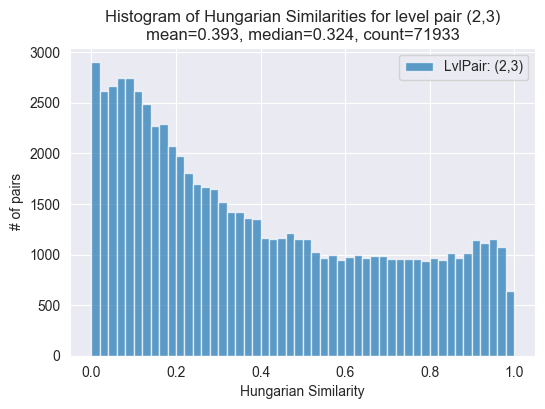

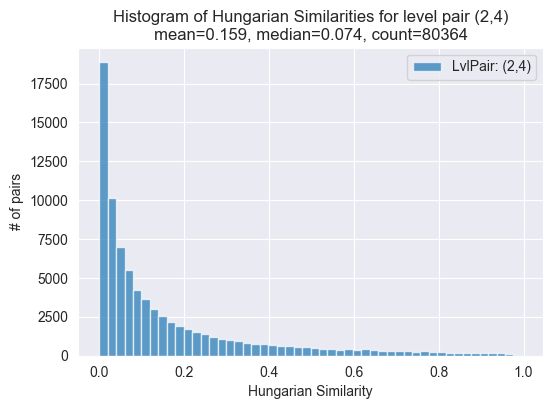

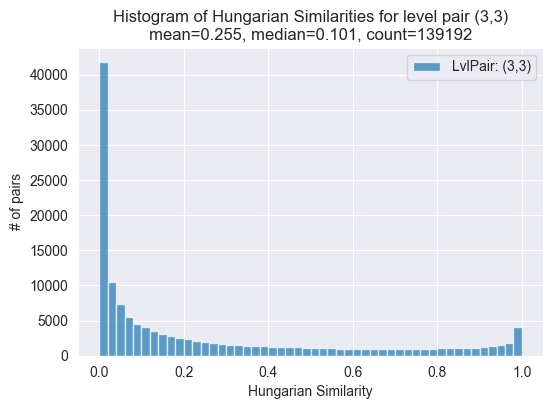

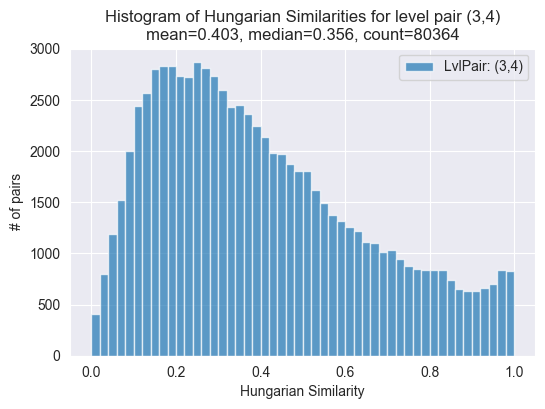

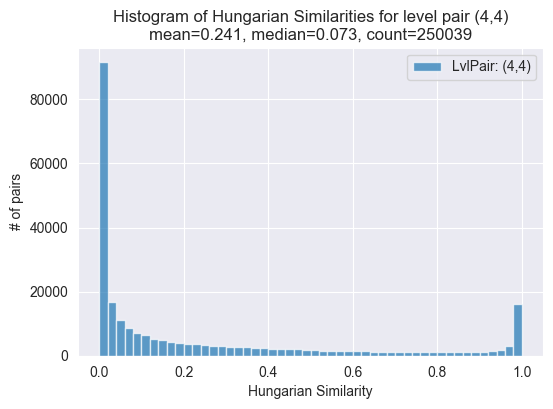

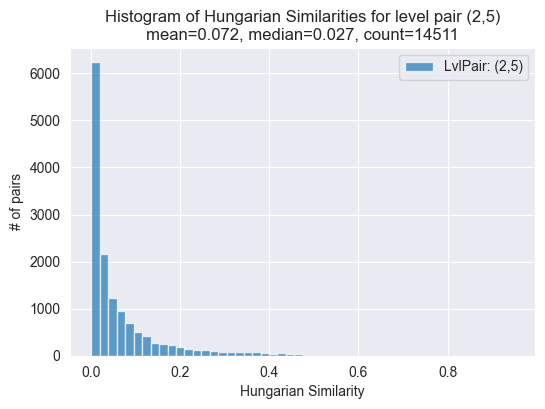

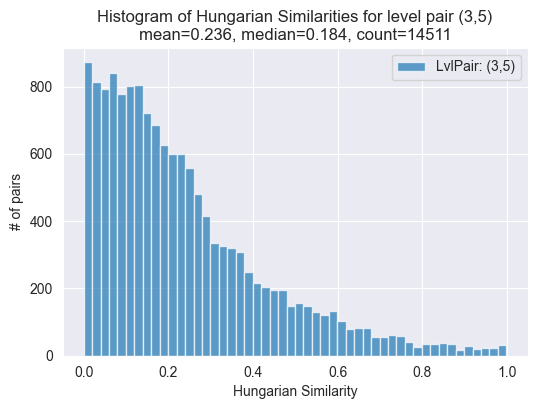

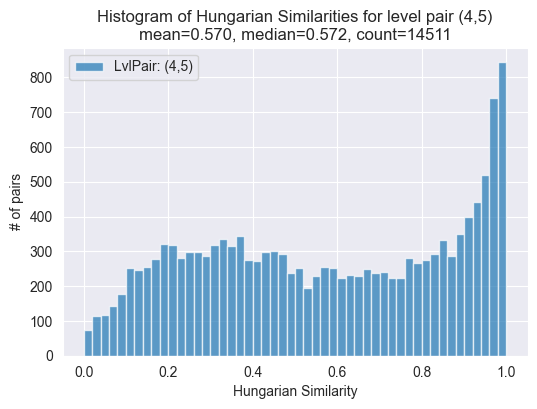

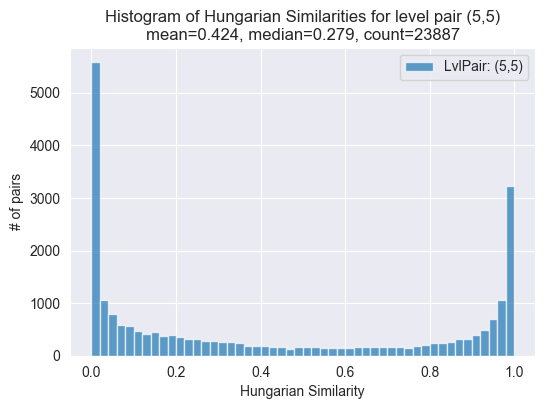

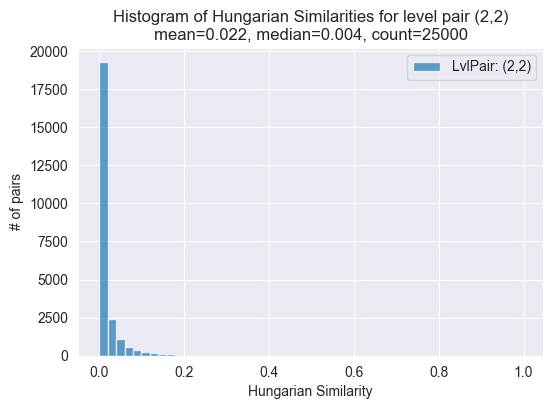

In [13]:
# Optionally plot each level pair in a separate figure:
plot_histograms_by_level_pairs(all_level_sims_hung, mode="Hungarian")

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_34184/1573719068.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Level Pair", y="Similarity", data=df, palette="Set3")


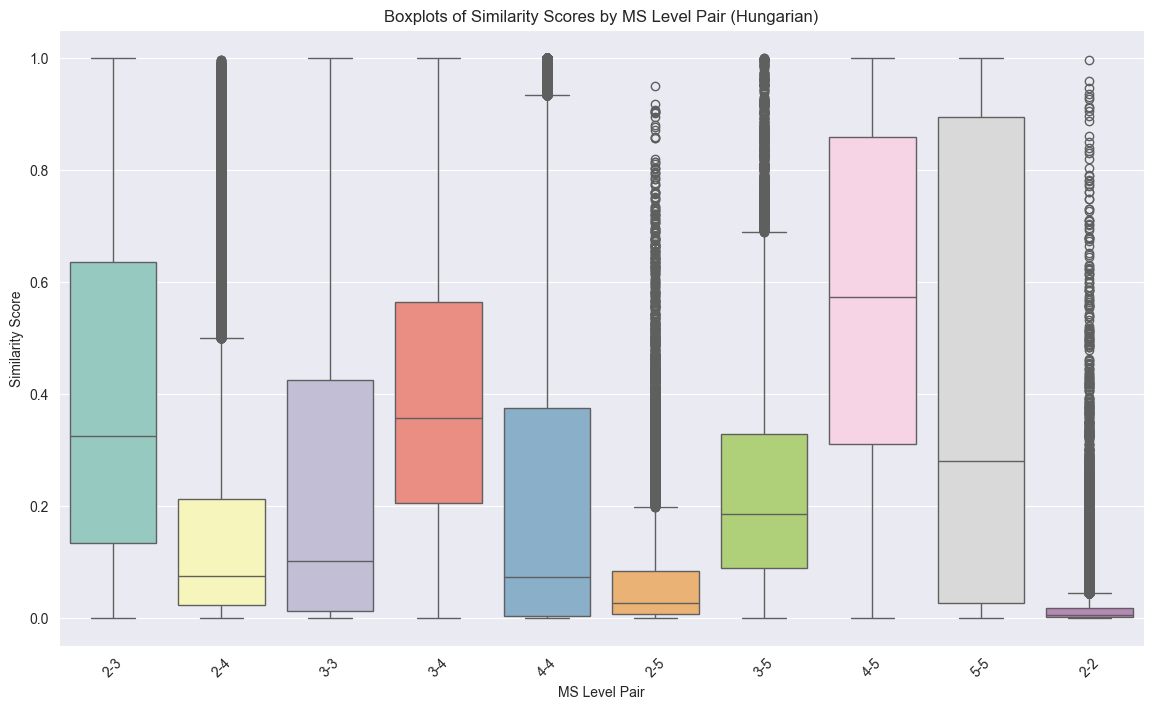

In [14]:
plot_boxplots(all_level_sims_hung, "Boxplots of Similarity Scores by MS Level Pair (Hungarian)")

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_34184/1573719068.py:79: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sims, label=label, shade=False)
/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_34184/1573719068.py:79: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sims, label=label, shade=False)
/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_34184/1573719068.py:79: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sims, label=label, shade=False)
/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_34184/1573719068.py:79: FutureWarning: 

`shade` is now deprecated in favor of `fil

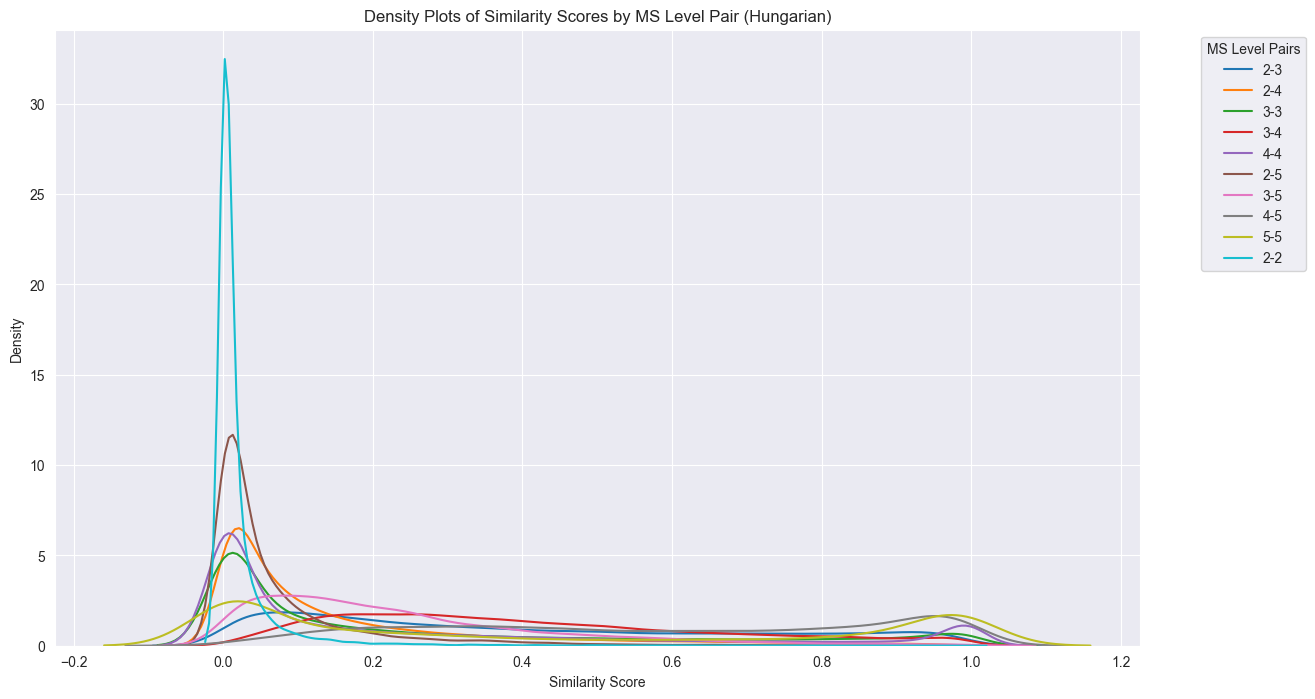

In [15]:
plot_density(all_level_sims_hung, "Density Plots of Similarity Scores by MS Level Pair (Hungarian)")

In [16]:
# Generate the summary tables
ks_summary_df, aic_summary_df = summarize_all_level_pairs(all_level_sims_hung, top_n=5)

# Display KS Summary Table
print("\nTop 5 Best-Fitting Distributions Based on KS Statistic:")
display(ks_summary_df)

# Display AIC Summary Table
print("\nTop 5 Best-Fitting Distributions Based on AIC:")
display(aic_summary_df)


Fitting distributions for Level Pair (2, 3) with 71933 scores...

Fitting distributions for Level Pair (2, 4) with 80364 scores...

Fitting distributions for Level Pair (3, 3) with 139192 scores...

Fitting distributions for Level Pair (3, 4) with 80364 scores...

Fitting distributions for Level Pair (4, 4) with 250039 scores...

Fitting distributions for Level Pair (2, 5) with 14511 scores...

Fitting distributions for Level Pair (3, 5) with 14511 scores...

Fitting distributions for Level Pair (4, 5) with 14511 scores...

Fitting distributions for Level Pair (5, 5) with 23887 scores...

Fitting distributions for Level Pair (2, 2) with 25000 scores...

Top 5 Best-Fitting Distributions Based on KS Statistic:


,Distribution,Parameters,KS Statistic,KS p-value,Level Pair
0,beta,"(0.9529189668699778, 2.1430406223244924, -1.57...",0.047143,2.277159e-139,"2,3"
1,weibull_min,"(1.2124347883121667, -0.0008508629037633147, 0...",0.062610,1.398716e-245,"2,3"
2,gamma,"(1.247510526508711, -0.0007953053784309521, 0....",0.065866,9.182752e-272,"2,3"
3,lognorm,"(0.6717420620441968, -0.09993517911944097, 0.4...",0.071538,1.439707e-320,"2,3"
4,weibull_max,"(141373146.89470714, 32791666.38793264, 327916...",0.074026,0.000000e+00,"2,3"
5,weibull_min,"(0.7453535431238589, -1.0705943309842896e-30, ...",0.030777,1.436386e-66,"2,4"
6,pareto,"(2.002329621328352, -0.18230990420184898, 0.18...",0.049466,2.491512e-171,"2,4"
7,gamma,"(0.576079908061335, -5.4385845413828965e-31, 0...",0.063937,4.651442e-286,"2,4"
8,beta,"(0.46856270451909277, 2.495022325184895, -4.29...",0.080394,0.000000e+00,"2,4"
9,expon,"(0.0, 0.15920017039996986)",0.140059,0.000000e+00,"2,4"



Top 5 Best-Fitting Distributions Based on AIC:


,Distribution,Parameters,AIC,Level Pair
0,beta,"(0.9529189668699778, 2.1430406223244924, -1.57...",-3.654443e+03,"2,3"
1,uniform,"(0.0, 0.9995800041106572)",-5.643582e+01,"2,3"
2,weibull_min,"(1.2124347883121667, -0.0008508629037633147, 0...",6.175381e+03,"2,3"
3,gamma,"(1.247510526508711, -0.0007953053784309521, 0....",7.710433e+03,"2,3"
4,expon,"(0.0, 0.39291368614045286)",9.475372e+03,"2,3"
5,lognorm,"(119.93913359446574, -5e-324, 1.46519666918618...",-2.642031e+06,"2,4"
6,beta,"(0.46856270451909277, 2.495022325184895, -4.29...",-2.851602e+05,"2,4"
7,gamma,"(0.576079908061335, -5.4385845413828965e-31, 0...",-2.607937e+05,"2,4"
8,weibull_min,"(0.7453535431238589, -1.0705943309842896e-30, ...",-2.183247e+05,"2,4"
9,pareto,"(2.002329621328352, -0.18230990420184898, 0.18...",-1.441574e+05,"2,4"


## Sample

In [17]:
sampled_all_level_sims = downsample_all_level_sims(all_level_sims_hung, random_seed=42)

Desired sample size per group set to the smallest group size: 14511
Downsampled group (2, 3) from 71933 to 14511
Downsampled group (2, 4) from 80364 to 14511
Downsampled group (3, 3) from 139192 to 14511
Downsampled group (3, 4) from 80364 to 14511
Downsampled group (4, 4) from 250039 to 14511
Group (2, 5) already has 14511 samples; no downsampling performed.
Group (3, 5) already has 14511 samples; no downsampling performed.
Group (4, 5) already has 14511 samples; no downsampling performed.
Downsampled group (5, 5) from 23887 to 14511
Downsampled group (2, 2) from 25000 to 14511


In [18]:
# Print average for each level pair
for level_pair, vals in sampled_all_level_sims.items():
    stats_lv = summarize_similarity_distribution(vals)
    print(f"Level pair {level_pair} -> {stats_lv}")

Level pair (2, 3) -> {'mean': 0.3895772785884555, 'std': 0.29461775191072426, 'median': 0.31892756927439475, 'count': 14511, 'q1': 0.12848130949789893, 'q3': 0.6295302092386197, 'IQR': 0.5010488997407208, 'range': 0.9981312036873685, 'skewness': 0.49964531955384306, 'kurtosis': -1.0301042455736054, 'ks_p': 1.8194388617331363e-144, 'is_normal': False}
Level pair (2, 4) -> {'mean': 0.1582080123453258, 'std': 0.20082681025069246, 'median': 0.07434581860799871, 'count': 14511, 'q1': 0.022355794538197436, 'q3': 0.21048808256223073, 'IQR': 0.18813228802403328, 'range': 0.9923296668872803, 'skewness': 1.8463712722566081, 'kurtosis': 2.993997996379102, 'ks_p': 0.0, 'is_normal': False}
Level pair (3, 3) -> {'mean': 0.25372780663116606, 'std': 0.3107297783603231, 'median': 0.10284145138636115, 'count': 14511, 'q1': 0.011136119664994962, 'q3': 0.4197091894084464, 'IQR': 0.4085730697434515, 'range': 0.9999735615914951, 'skewness': 1.1479251217540065, 'kurtosis': -0.035122993904764144, 'ks_p': 0.0,

In [19]:
# Summarize and perform statistical tests for hungarian_fn similarities
print("\n--- Statistical Analysis for Sampled Hungarian Similarity Function ---")
comparison_results_hung = perform_statistical_tests_with_effect_sizes(sampled_all_level_sims, alpha=0.05)
report_comparison_results_with_effect_sizes(comparison_results_hung)


--- Statistical Analysis for Sampled Hungarian Similarity Function ---
Group 1 Group 2           Test Used   Statistic       p-value  Adjusted Alpha  Significant  Effect Size          Effect Size Type
    2-3     2-4 Mann-Whitney U test 160369650.5  0.000000e+00        0.001111         True    -0.523202 Rank-Biserial Correlation
    4-5     2-2 Mann-Whitney U test 208082851.0  0.000000e+00        0.001111         True    -0.976385 Rank-Biserial Correlation
    3-3     2-2 Mann-Whitney U test 162813708.0  0.000000e+00        0.001111         True    -0.546416 Rank-Biserial Correlation
    3-4     4-4 Mann-Whitney U test 152822562.0  0.000000e+00        0.001111         True    -0.451519 Rank-Biserial Correlation
    3-4     2-5 Mann-Whitney U test 195131602.0  0.000000e+00        0.001111         True    -0.853373 Rank-Biserial Correlation
    3-4     3-5 Mann-Whitney U test 149576690.0  0.000000e+00        0.001111         True    -0.420690 Rank-Biserial Correlation
    3-4     4-5 Ma

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_34184/1573719068.py:79: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sims, label=label, shade=False)
/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_34184/1573719068.py:79: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sims, label=label, shade=False)
/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_34184/1573719068.py:79: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sims, label=label, shade=False)
/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_34184/1573719068.py:79: FutureWarning: 

`shade` is now deprecated in favor of `fil

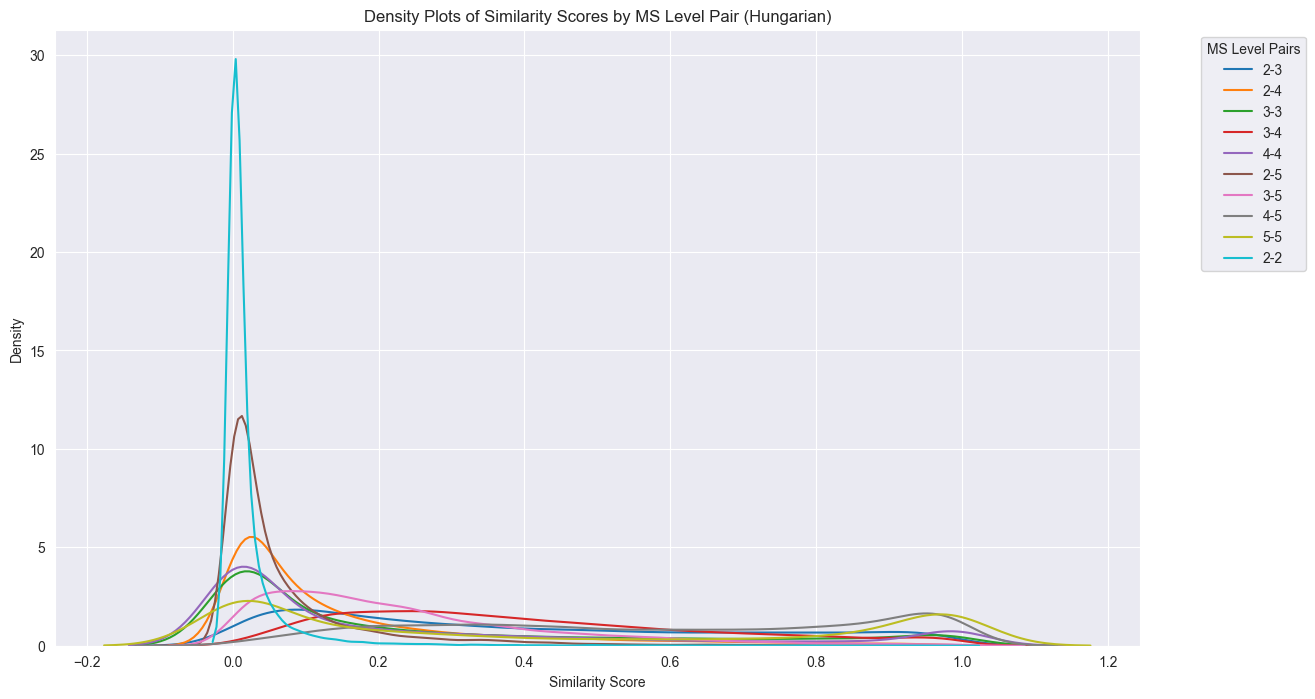

In [20]:
plot_density(sampled_all_level_sims, "Density Plots of Similarity Scores by MS Level Pair (Hungarian)")

## Correlation

,Level_A,Level_B,Similarity_Score,Avg_Level,Level_Difference,Level_Pair
0,2,3,0.950707,2.5,1,"2,3"
1,2,3,0.540661,2.5,1,"2,3"
2,2,3,0.175046,2.5,1,"2,3"
3,2,3,0.830678,2.5,1,"2,3"
4,2,3,0.082853,2.5,1,"2,3"


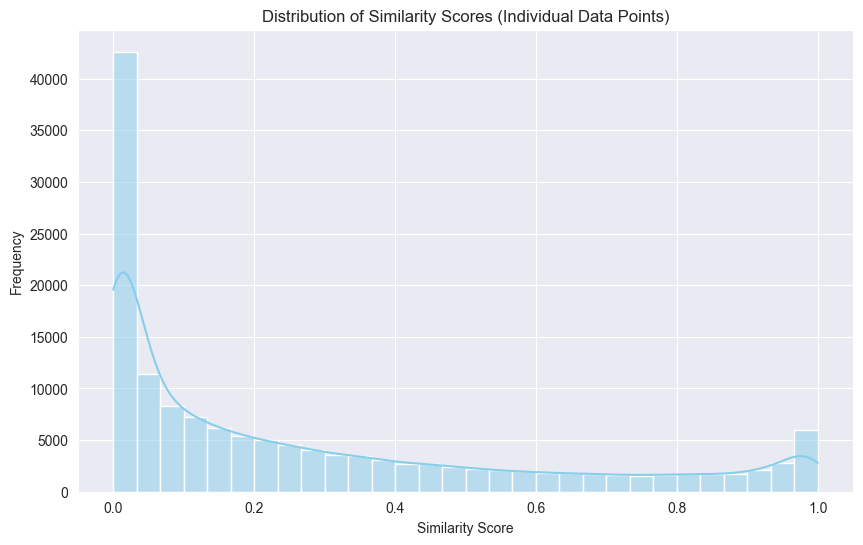

Skewness of Similarity_Score: 1.045
Applied log transformation to Similarity_Score.
Skewness after log transformation: 0.814


In [21]:
data = []
for level_pair, sims in sampled_all_level_sims.items():
    lvlA, lvlB = level_pair
    for sim in sims:
        data.append({
            'Level_A': lvlA,
            'Level_B': lvlB,
            'Similarity_Score': sim
        })

df = pd.DataFrame(data)

# Compute Avg_Level and Level_Difference
df['Avg_Level'] = df[['Level_A', 'Level_B']].mean(axis=1)
df['Level_Difference'] = abs(df['Level_A'] - df['Level_B'])

df['Level_Pair'] = df.apply(lambda row: f"{int(row['Level_A'])},{int(row['Level_B'])}", axis=1)

# Group by Level Pair and compute descriptive statistics
grouped = df.groupby(['Level_A', 'Level_B'])

# Compute mean, median, std, and count similarity scores
stats_df = grouped['Similarity_Score'].agg(['mean', 'median', 'std', 'count']).reset_index()
stats_df.rename(columns={
    'mean': 'Mean_Similarity',
    'median': 'Median_Similarity',
    'std': 'Std_Similarity',
    'count': 'Count'
}, inplace=True)

stats_df['Avg_Level'] = stats_df[['Level_A', 'Level_B']].mean(axis=1)
stats_df['Level_Difference'] = abs(stats_df['Level_A'] - stats_df['Level_B'])

# Check for skewness
skewness = df['Similarity_Score'].skew()
print(f"Skewness of Similarity_Score: {skewness:.3f}")

# If skewness is significant (e.g., |skewness| > 1),
if abs(skewness) > 1:
    df['Similarity_Score_Log'] = np.log(df['Similarity_Score'] + 1)  # Adding 1 to handle zero or negative values
    print("Applied log transformation to Similarity_Score.")

    skewness_log = df['Similarity_Score_Log'].skew()
    print(f"Skewness after log transformation: {skewness_log:.3f}")
    
    # Use the transformed variable in regression
    dependent_var = 'Similarity_Score_Log'
else:
    dependent_var = 'Similarity_Score'

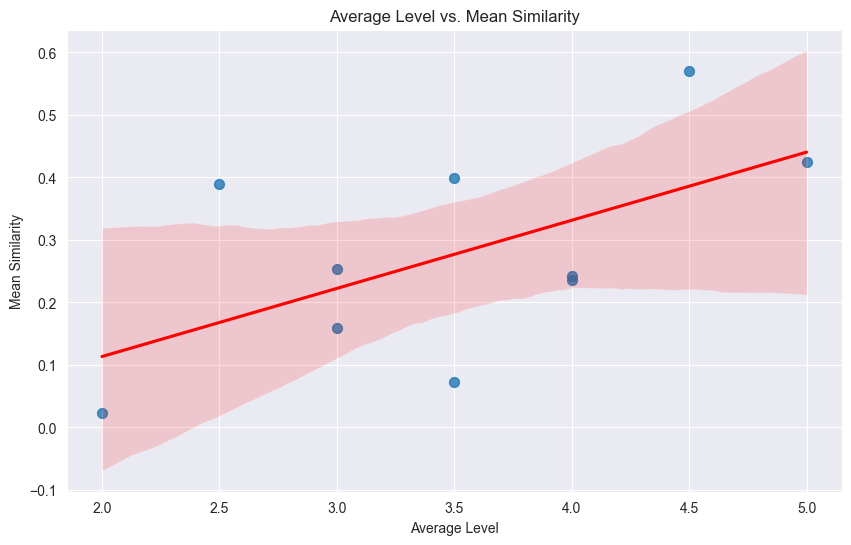

In [22]:
plt.figure(figsize=(10, 6))
sns.regplot(x='Avg_Level', y='Mean_Similarity', data=stats_df, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Average Level vs. Mean Similarity')
plt.xlabel('Average Level')
plt.ylabel('Mean Similarity')
plt.show()

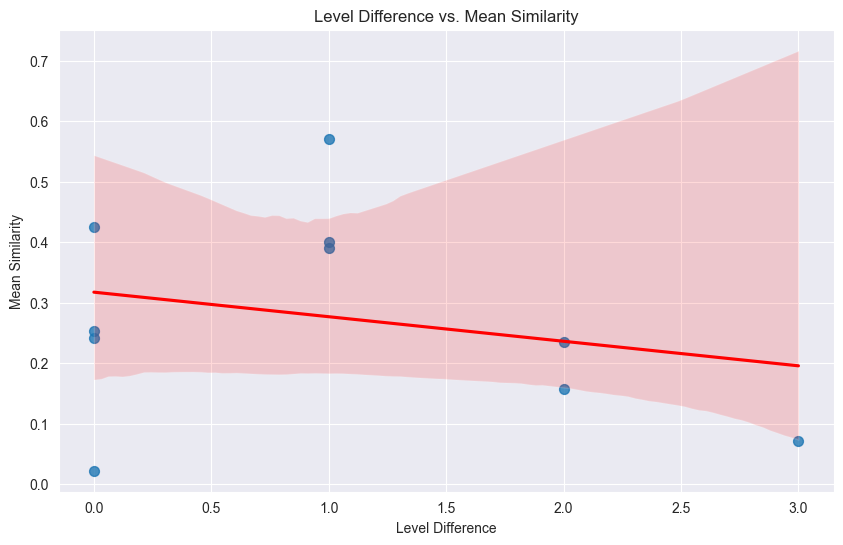

In [23]:
plt.figure(figsize=(10, 6))
sns.regplot(x='Level_Difference', y='Mean_Similarity', data=stats_df, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Level Difference vs. Mean Similarity')
plt.xlabel('Level Difference')
plt.ylabel('Mean Similarity')
plt.show()

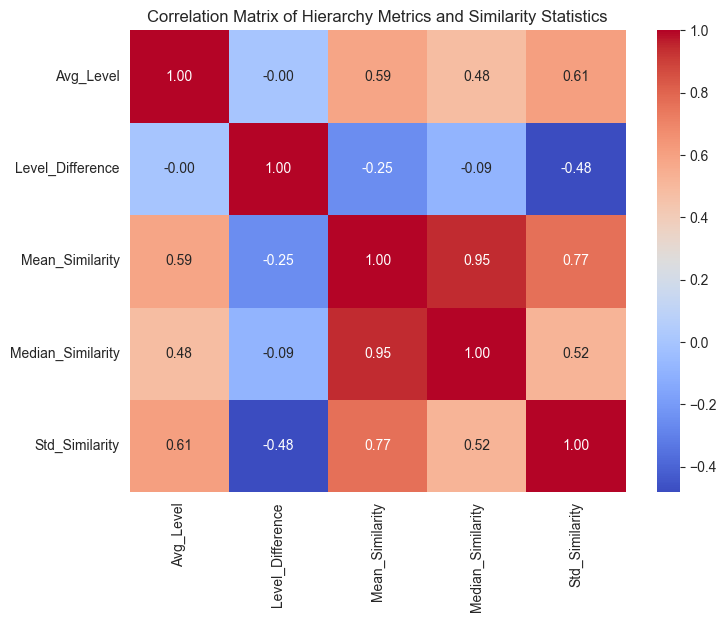

In [24]:
# Heatmap of Correlation Matrix
corr_matrix = stats_df[['Avg_Level', 'Level_Difference', 'Mean_Similarity', 'Median_Similarity', 'Std_Similarity']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Hierarchy Metrics and Similarity Statistics')
plt.show()

In [25]:
# Spearman Correlation between Level_Difference and Mean_Similarity
spearman_corr_ld, spearman_p_ld = stats.spearmanr(stats_df['Avg_Level'], stats_df['Mean_Similarity'])
print(f"Spearman Correlation between Avg_Level and Mean_Similarity: {spearman_corr_ld:.3f}")
print(f"P-value: {spearman_p_ld:.3f}\n")

Spearman Correlation between Avg_Level and Mean_Similarity: 0.569
P-value: 0.086



In [26]:
# Spearman correlation between Avg_Level and Similarity_Score
spearman_corr, spearman_p = stats.spearmanr(df['Avg_Level'], df['Similarity_Score'])
print(f"Spearman Correlation between Avg_Level and Similarity_Score: {spearman_corr:.3f}")
print(f"P-value: {spearman_p:.3f}")

Spearman Correlation between Avg_Level and Similarity_Score: 0.295
P-value: 0.000


In [27]:
# Spearman Correlation between Level_Difference and Mean_Similarity
spearman_corr_ld, spearman_p_ld = stats.spearmanr(stats_df['Level_Difference'], stats_df['Mean_Similarity'])
print(f"Spearman Correlation between Level_Difference and Mean_Similarity: {spearman_corr_ld:.3f}")
print(f"P-value: {spearman_p_ld:.3f}\n")

Spearman Correlation between Level_Difference and Mean_Similarity: -0.261
P-value: 0.467



In [28]:
# Spearman Correlation between Level_Difference and Mean_Similarity
spearman_corr_ld, spearman_p_ld = stats.spearmanr(df['Level_Difference'], df['Similarity_Score'])
print(f"Spearman Correlation between Level_Difference and Similarity_Score: {spearman_corr_ld:.3f}")
print(f"P-value: {spearman_p_ld:.3f}\n")

Spearman Correlation between Level_Difference and Similarity_Score: 0.042
P-value: 0.000



## Intra group investigation

In [29]:
warnings.filterwarnings('ignore')
# Filter intergroup data
intergroup_pairs = [(2,2), (3,3), (4,4), (5,5)]
intergroup_df = df[df['Level_Pair'].isin([f"{a},{b}" for a,b in intergroup_pairs])].copy()

# Ensure 'Level_Pair' is categorical
intergroup_df['Level_Pair'] = intergroup_df['Level_Pair'].astype('category')

# Check for NaNs and remove if any
intergroup_df = intergroup_df.dropna(subset=['Similarity_Score'])

# Perform Kruskal-Wallis H-test
groups = intergroup_df.groupby('Level_Pair')['Similarity_Score'].apply(list)

stat, p = kruskal(*groups)
print("Kruskal-Wallis H-test for Intergroup Comparison:")
print(f"Statistic: {stat:.3f}, p-value: {p:.3f}\n")

Kruskal-Wallis H-test for Intergroup Comparison:
Statistic: 10237.636, p-value: 0.000



In [30]:
# Get unique groups
groups = intergroup_df.groupby('Level_Pair')['Similarity_Score'].apply(list)

# Get all pairwise combinations
pairwise = list(combinations(groups.index, 2))

results = []
p_values = []

for g1, g2 in pairwise:
    stat, p = stats.mannwhitneyu(groups[g1], groups[g2], alternative='two-sided')
    results.append((g1, g2, stat, p))
    p_values.append(p)

# Adjust p-values for multiple comparisons using Bonferroni correction
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

# Compile results
comparison_results = []
for i, (g1, g2, stat, p) in enumerate(results):
    comparison_results.append({
        "Group 1": g1,
        "Group 2": g2,
        "Statistic": stat,
        "p-value": p,
        "p-value Adjusted": pvals_corrected[i],
        "Significant": reject[i]
    })

comparison_df = pd.DataFrame(comparison_results)

print("Pairwise Mann-Whitney U Test with Bonferroni Correction:")
print(comparison_df)

Pairwise Mann-Whitney U Test with Bonferroni Correction:
  Group 1 Group 2    Statistic        p-value  p-value Adjusted  Significant
0     2,2     3,3   47755413.0   0.000000e+00      0.000000e+00         True
1     2,2     4,4   62165009.0   0.000000e+00      0.000000e+00         True
2     2,2     5,5   41574627.0   0.000000e+00      0.000000e+00         True
3     3,3     4,4  112660555.5   3.826917e-25      2.296150e-24         True
4     3,3     5,5   82679928.5  1.088153e-220     6.528918e-220         True
5     4,4     5,5   78983894.5  3.742394e-299     2.245437e-298         True


In [31]:
intergroup_df['Hierarchy_Level'] = intergroup_df['Level_Pair'].apply(lambda x: int(x.split(',')[0]))

# Calculate summary statistics
summary_df = intergroup_df.groupby('Hierarchy_Level')['Similarity_Score'].agg(['mean', 'median', 'std', 'count']).reset_index()
print("Summary Statistics by Hierarchy Level:")
print(summary_df)

Summary Statistics by Hierarchy Level:
  Hierarchy_Level      mean    median       std  count
0               2  0.022358  0.004225  0.062238  14511
1               3  0.253728  0.102841  0.310740  14511
2               4  0.242289  0.075179  0.322675  14511
3               5  0.425280  0.280398  0.399463  14511


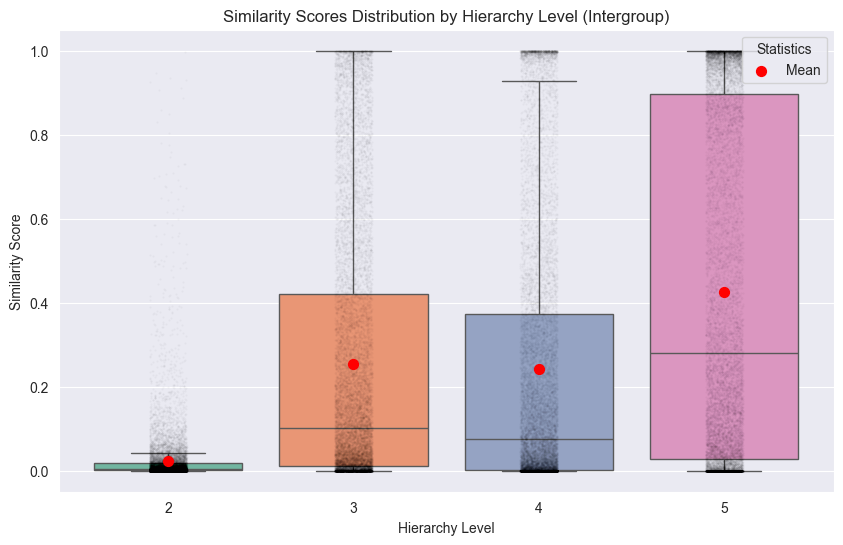

In [32]:
plt.figure(figsize=(10, 6))

sns.boxplot(
    x='Hierarchy_Level', 
    y='Similarity_Score', 
    data=intergroup_df, 
    palette='Set2', 
    showfliers=False  
)

sns.stripplot(
    x='Hierarchy_Level', 
    y='Similarity_Score', 
    data=intergroup_df, 
    color='black', 
    alpha=0.03,  
    jitter=True, 
    size=1.45
)

# Add mean values
mean_values = intergroup_df.groupby('Hierarchy_Level')['Similarity_Score'].mean().reset_index()

positions = range(len(mean_values))  
plt.scatter(
    x=positions, 
    y=mean_values['Similarity_Score'], 
    color='red', 
    label='Mean', 
    zorder=5, 
    s=50
)

plt.legend(title='Statistics', loc='upper right')

plt.title('Similarity Scores Distribution by Hierarchy Level (Intergroup)')
plt.xlabel('Hierarchy Level')
plt.ylabel('Similarity Score')

plt.show()

In [33]:
# Perform Spearman's Rank Correlation between Hierarchy_Level and Similarity_Score
spearman_corr, spearman_p = stats.spearmanr(intergroup_df['Hierarchy_Level'], intergroup_df['Similarity_Score'])
print("Spearman Correlation for Intergroup Comparison:")
print(f"Correlation: {spearman_corr:.3f}, p-value: {spearman_p:.3f}\n")

# Interpretation
if spearman_p < 0.05:
    print("There is a significant monotonic relationship between Hierarchy Level and Similarity Score in the Intergroup.\n")
    if spearman_corr > 0:
        print("Higher hierarchy levels are associated with higher similarity scores.\n")
    else:
        print("Higher hierarchy levels are associated with lower similarity scores.\n")
else:
    print("No significant monotonic relationship found between Hierarchy Level and Similarity Score in the Intergroup.\n")

Spearman Correlation for Intergroup Comparison:
Correlation: 0.368, p-value: 0.000

There is a significant monotonic relationship between Hierarchy Level and Similarity Score in the Intergroup.

Higher hierarchy levels are associated with higher similarity scores.



## Infra group investigation

In [34]:
# Filter outer group data
outer_group_pairs = [(2,3), (2,4), (3,4), (2,5), (3,5), (4,5)]
outer_group_df = df[df['Level_Pair'].isin([f"{a},{b}" for a,b in outer_group_pairs])]

Spearman Correlation (Balanced): -0.639, p-value: 0.000
Regression Slope: -0.191, Intercept: 0.624


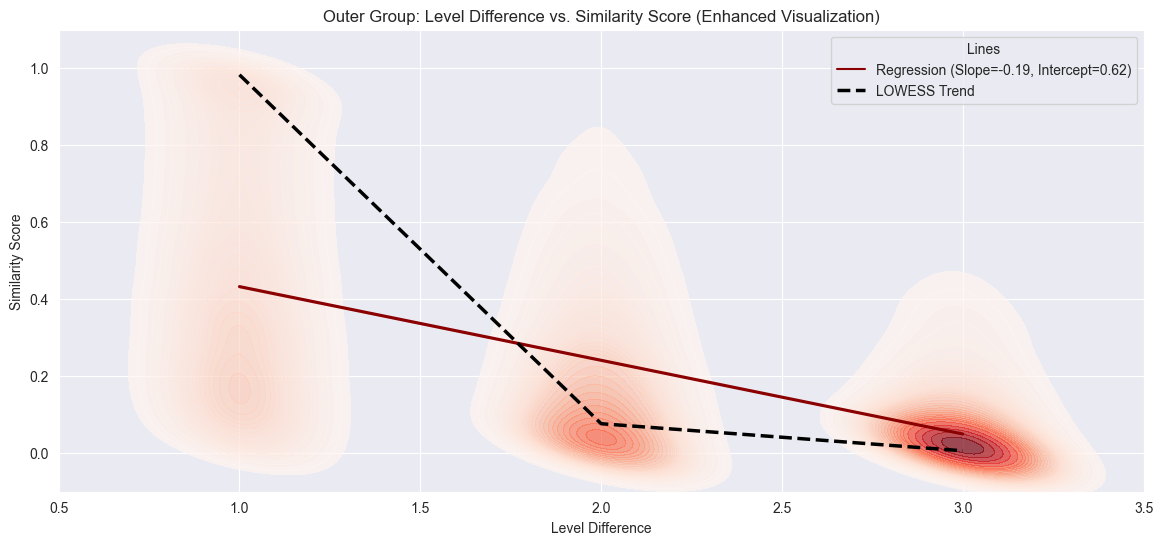

Sample counts per Level Difference after balancing:
Level_Difference
1    14511
2    14511
3    14511
Name: count, dtype: int64


In [35]:
# Group by Level Difference and find the minimum sample size
grouped = outer_group_df.groupby('Level_Difference')
min_samples = grouped.size().min()

# Downsample each group to the minimum size
balanced_df = grouped.apply(lambda x: x.sample(n=min_samples, random_state=42)).reset_index(drop=True)

# Compute Spearman correlation for the balanced group
spearman_corr, spearman_p = spearmanr(balanced_df['Level_Difference'], balanced_df['Similarity_Score'])
print(f"Spearman Correlation (Balanced): {spearman_corr:.3f}, p-value: {spearman_p:.3f}")

# Compute regression slope and intercept using linear regression
slope, intercept, r_value, p_value, std_err = linregress(balanced_df['Level_Difference'], balanced_df['Similarity_Score'])
print(f"Regression Slope: {slope:.3f}, Intercept: {intercept:.3f}")

# LOWESS Smoothing for the downward trend
lowess_smoothed = lowess(
    balanced_df['Similarity_Score'], 
    balanced_df['Level_Difference'], 
    frac=0.3
)

fig, ax = plt.subplots(figsize=(14, 6)) 

# KDE plot for density visualization
sns.kdeplot(
    x='Level_Difference',
    y='Similarity_Score',
    data=balanced_df,
    fill=True,
    cmap='Reds',  
    alpha=0.7,    
    ax=ax,
    thresh=0.05,  
    levels=40    
)

# Regression line with confidence interval
sns.regplot(
    x='Level_Difference',
    y='Similarity_Score',
    data=balanced_df,
    scatter=False,
    color='darkred',  
    ci=95, 
    n_boot=2000,
    ax=ax
)

ax.plot([], [], color='darkred', label=f"Regression (Slope={slope:.2f}, Intercept={intercept:.2f})")

# Plot the smoothed LOWESS curve
ax.plot(
    lowess_smoothed[:, 0], 
    lowess_smoothed[:, 1], 
    color='black', 
    linestyle='--', 
    linewidth=2.5, 
    label='LOWESS Trend'
)


plt.title('Outer Group: Level Difference vs. Similarity Score (Enhanced Visualization)')
plt.xlabel('Level Difference')
plt.ylabel('Similarity Score')
plt.xlim(balanced_df['Level_Difference'].min() - 0.5, balanced_df['Level_Difference'].max() + 0.5)  
plt.ylim(balanced_df['Similarity_Score'].min() - 0.1, balanced_df['Similarity_Score'].max() + 0.1)

plt.legend(title='Lines', loc='upper right')

plt.show()

sample_counts = balanced_df['Level_Difference'].value_counts()
print("Sample counts per Level Difference after balancing:")
print(sample_counts)

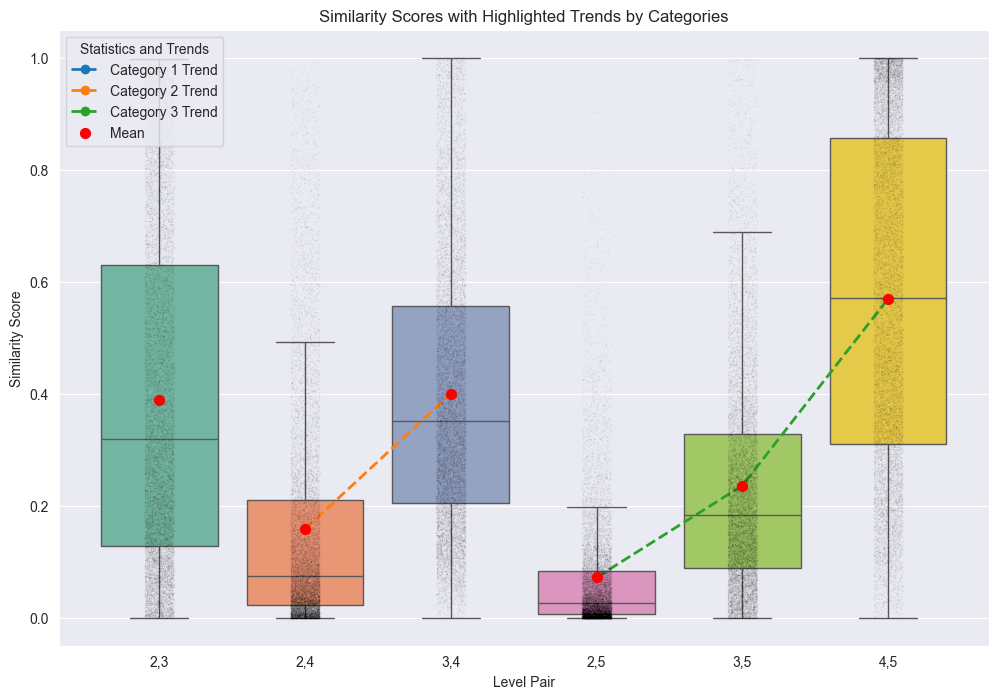

In [36]:
# Categorize the Level_Pairs into three groups for highlighting trends
def categorize_level_pair(level_pair):
    if level_pair == "2,3":
        return "Category 1"
    elif level_pair in ["2,4", "3,4"]:
        return "Category 2"
    elif level_pair in ["2,5", "3,5", "4,5"]:
        return "Category 3"
    return "Other"

outer_group_df['Category'] = outer_group_df['Level_Pair'].apply(categorize_level_pair)

plt.figure(figsize=(12, 8))

# Boxplot for Outer Group
sns.boxplot(
    x='Level_Pair', 
    y='Similarity_Score', 
    data=outer_group_df, 
    palette='Set2', 
    showfliers=False  
)

sns.stripplot(
    x='Level_Pair', 
    y='Similarity_Score', 
    data=outer_group_df, 
    color='black', 
    alpha=0.05,  
    jitter=True, 
    size=1
)

# Add mean values
mean_values = outer_group_df.groupby(['Category', 'Level_Pair'])['Similarity_Score'].mean().reset_index()

# Plot the means and connect them within categories
for category, group_data in mean_values.groupby('Category'):
    positions = [list(outer_group_df['Level_Pair'].unique()).index(pair) for pair in group_data['Level_Pair']]
    plt.plot(
        positions, 
        group_data['Similarity_Score'], 
        label=f'{category} Trend', 
        linestyle='--', 
        marker='o', 
        linewidth=2
    )


plt.scatter(
    x=[list(outer_group_df['Level_Pair'].unique()).index(pair) for pair in mean_values['Level_Pair']], 
    y=mean_values['Similarity_Score'], 
    color='red', 
    label='Mean', 
    zorder=5, 
    s=50
)

plt.legend(title='Statistics and Trends', loc='upper left')

plt.title('Similarity Scores with Highlighted Trends by Categories')
plt.xlabel('Level Pair')
plt.ylabel('Similarity Score')

plt.show()

In [37]:
# Define subsets based on user observation
subset1_pairs = [(2,4), (3,4)]
subset2_pairs = [(2,5), (3,5), (4,5)]

subset1_df = outer_group_df[outer_group_df['Level_Pair'].isin([f"{a},{b}" for a,b in subset1_pairs])]
subset2_df = outer_group_df[outer_group_df['Level_Pair'].isin([f"{a},{b}" for a,b in subset2_pairs])]

# Spearman Correlation for Subset 1
spearman_corr_sub1, spearman_p_sub1 = stats.spearmanr(subset1_df['Level_Difference'], subset1_df['Similarity_Score'])
print("Spearman Correlation for Outer Group Subset 1 (2,4 and 3,4):")
print(f"Correlation: {spearman_corr_sub1:.3f}, p-value: {spearman_p_sub1:.3f}\n")

# Spearman Correlation for Subset 2
spearman_corr_sub2, spearman_p_sub2 = stats.spearmanr(subset2_df['Level_Difference'], subset2_df['Similarity_Score'])
print("Spearman Correlation for Outer Group Subset 2 (2,5; 3,5; 4,5):")
print(f"Correlation: {spearman_corr_sub2:.3f}, p-value: {spearman_p_sub2:.3f}\n")

Spearman Correlation for Outer Group Subset 1 (2,4 and 3,4):
Correlation: -0.550, p-value: 0.000

Spearman Correlation for Outer Group Subset 2 (2,5; 3,5; 4,5):
Correlation: -0.731, p-value: 0.000



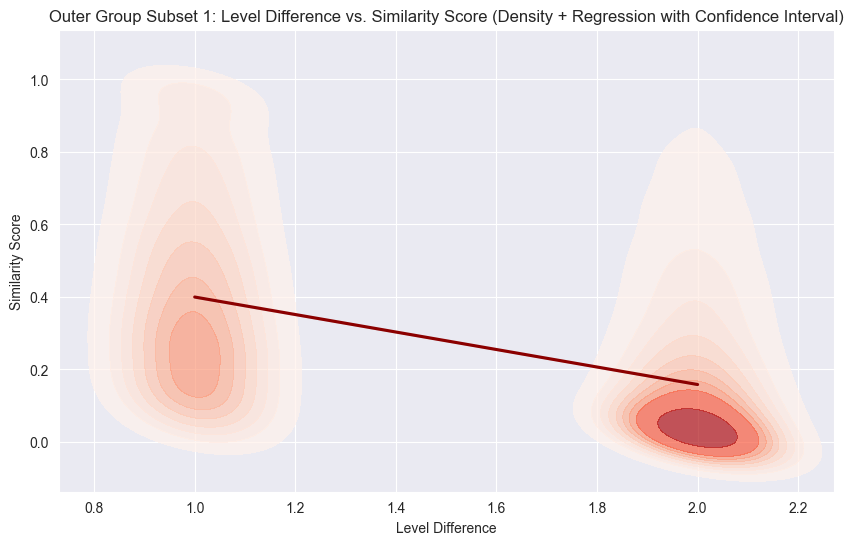

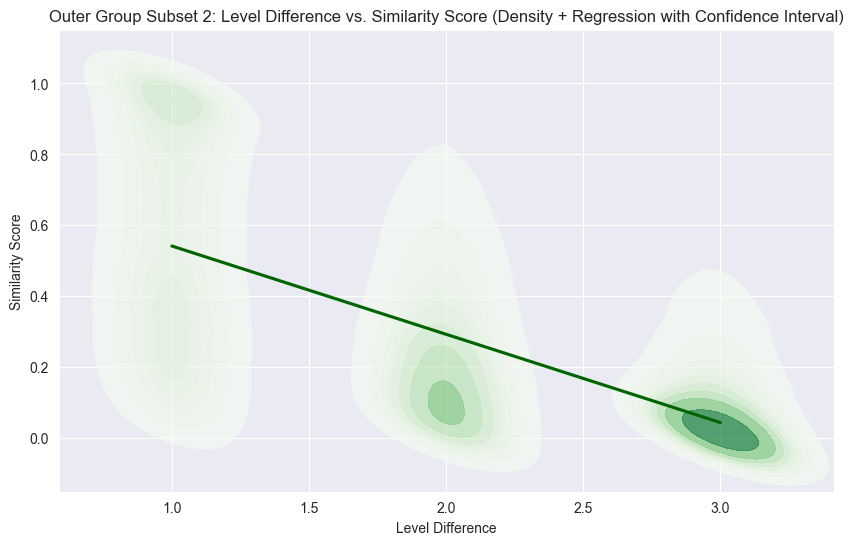

In [38]:
# Visualization for Subset 1: KDE + Regression Line with Confidence Interval
plt.figure(figsize=(10, 6))
sns.kdeplot(
    x='Level_Difference',
    y='Similarity_Score',
    data=subset1_df,
    fill=True,
    cmap='Reds',
    thresh=0.05,
    alpha=0.7
)
sns.regplot(
    x='Level_Difference',
    y='Similarity_Score',
    data=subset1_df,
    scatter=False,
    color='darkred',
    ci=95  
)
plt.title('Outer Group Subset 1: Level Difference vs. Similarity Score (Density + Regression with Confidence Interval)')
plt.xlabel('Level Difference')
plt.ylabel('Similarity Score')
plt.show()

# Visualization for Subset 2: KDE + Regression Line with Confidence Interval
plt.figure(figsize=(10, 6))
sns.kdeplot(
    x='Level_Difference',
    y='Similarity_Score',
    data=subset2_df,
    fill=True,
    cmap='Greens',
    thresh=0.05,
    alpha=0.7
)
sns.regplot(
    x='Level_Difference',
    y='Similarity_Score',
    data=subset2_df,
    scatter=False,
    color='darkgreen',
    ci=55  
)
plt.title('Outer Group Subset 2: Level Difference vs. Similarity Score (Density + Regression with Confidence Interval)')
plt.xlabel('Level Difference')
plt.ylabel('Similarity Score')
plt.show()